# Advanced Tutorial: Creating Gold Annotation Labels with BRAT

This is a short tutorial on how to use BRAT (Brat Rapid Annotation Tool), an
online environment for collaborative text annotation. 

http://brat.nlplab.org/


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

# TO USE A DATABASE OTHER THAN SQLITE, USE THIS LINE
# Note that this is necessary for parallel execution amongst other things...
# os.environ['SNORKELDB'] = 'postgres:///snorkel-intro'

from snorkel import SnorkelSession
session = SnorkelSession()

## Step 1: Define a `Candidate` Type

We repeat our definition of the `Spouse` `Candidate` subclass from Parts II and III.

In [12]:
from snorkel.models import candidate_subclass, Document, Candidate

Spouse = candidate_subclass('Spouse', ['person1', 'person2'])

### a) Select an example `Candidate` and `Document` 

Candidates are divided into 3 splits, each mapped to a unique integer id:  
- 0: _training_  
- 1: _development_  
- 2: _testing_   

In this tutorial, we'll load our training set candidates and create gold labels for a document using the BRAT interface

## Step 2: Launching BRAT
BRAT runs as as seperate server application. Snorkel will automatically download and configure a BRAT instance for you. When you first initialize this server, you need to provide your applications `Candidate` type. For this tutorial, we use the `Spouse` relation defined above, which consists of a pair of `PERSON` named entities connected by marriage. 

Currently, we only support 1 relation type per-application. 

In [3]:
from snorkel.contrib.brat import BratAnnotator

brat = BratAnnotator(session, Spouse, encoding='utf-8')

Installing BRAT...
Launching BRAT server at http://localhost:8001 [pid=44647]...


### a) Initialize our document collection

BRAT creates a local copy of all the documents and annotations found in a `split` set. We initialize a document collection by defining a unique set name, _spouse/train_, and then passing in our training set candidates via the `split` id. Annotations are stored as plain text files in [standoff](http://brat.nlplab.org/standoff.html) format.

<img align="left" src="imgs/brat-login.jpg" width="200px" style="margin-right:50px">

After launching the BRAT annotator for the first time, you will need to login to begin editing annotations. Navigate your mouse to the upper right-hand corner of the BRAT interface (see Fig. 1) click 'login' and enter the following information:

- **login**: _brat_
- **password**: _brat_

Advanced BRAT users can setup multiple annotator accounts by adding USER/PASSWORD key pairs to the `USER_PASSWORD` dictionary found in `snokel/contrib/brat/brat-v1.3_Crunchy_Frog/config.py`. This is useful if you would like to keep track of multiple annotator judgements for later adjudication or use as labeling functions as per our tutorial on using [Snorkel for Crowdsourcing](https://github.com/HazyResearch/snorkel/blob/master/tutorials/crowdsourcing/Crowdsourced_Sentiment_Analysis.ipynb).

In [4]:
brat.init_collection("spouse/train", split=0)

We've already generated some BRAT annotations for you, so let's import an existing collection for purposes of this tutorial.

In [5]:
brat.import_collection("data/brat_spouse.zip", overwrite=True)

Imported archive to /Users/fries/code/workshop/snorkel/snorkel/contrib/brat/brat-v1.3_Crunchy_Frog/data/


### b) Launch BRAT Interface in a New Window
Once our collection is initialized, we can view specific documents for annotation. The default mode is to generate a HTML link to a new BRAT browser window. Click this link to connect to launch the annotator editor. 

Optionally, you can launch BRAT in an embedded window by calling:

    brat.view("spouse/train", doc, new_window=False)

In [8]:
doc_name = '5ede8912-59c9-4ba9-93df-c58cebb542b7'
doc = session.query(Document).filter(Document.name==doc_name).one()

brat.view("spouse/train", doc)

If you do not have a specific document to edit, you can optionally launch BRAT and use their file browser to navigate through all files found in the target collection.

In [10]:
brat.view("spouse/train")

## Step 3: Creating Gold Label Annotations
### a) Annotating Named Entities
`Spouse` relations consist of 2 `PERSON` named entities. When annotating our validation documents, 
the first task is to identify our target entities. In this tutorial, we will annotate all `PERSON` 
mentions found in our example document, though for your application you may choose to only label 
those that particpate in a true relation. 

<img align="right" src="imgs/brat-anno-dialog.jpg" width="400px" style="margin-left:50px">

Begin by selecting and highlighting the text corresponding to a `PERSON` entity. Once highlighted, an annotation dialog will appear on your screen (see image of the BRAT Annotation Dialog Window to the right). If this is correct, click ok. Repeat this for every entity you find in the document.

**Annotation Guidelines**

When developing gold label annotations, you should always discuss and agree on a set of _annotator guidelines_ to share with human labelers. These are the guidelines we used to label the `Spouse` relation:

- **<span style="color:red">Do not</span>** include formal titles associated with professional roles e.g., _**Pastor** Jeff_, _**Prime Minister** Prayut Chan-O-Cha_
- Do include English honorifics unrelated to a professional role, e.g., _**Mr.** John Cleese_.
- **<span style="color:red">Do not</span>** include family names/surnames that do not reference a single individual, e.g., _the Duggar family_.
- Do include informal titles, stage names, fictional characters, and nicknames, e.g., _**Dog the Bounty Hunter**_
- Include possessive's, e.g., _Anna**'s**_.

### b) Annotating Relations

To annotate `Spouse` relations, we look through all pairs of `PERSON` entities found within a single sentence. BRAT identifies the bounds of each sentence and renders a numbered row in the annotation window (see the left-most column in the image below).  

<img align="right" src="imgs/brat-relation.jpg" width="500px" style="margin-left:50px">

Annotating relations is done through simple drag and drop. Begin by clicking and holding on a single `PERSON` entity and then drag that entity to its corresponding spouse entity. That is it!

**Annotation Guidelines**

- Restrict `PERSON` pairs to those found in the same sentence.
- The order of `PERSON` arguments does not matter in this application.
- **<span style="color:red">Do not</span>** include relations where a `PERSON` argument is wrong or otherwise incomplete.

## Step 4: Scoring Models using BRAT Labels

### a) Evaluating System Recall

Creating gold validation data with BRAT is a critical evaluation step because it allows us to compute an estimate of our model's _true recall_. When we create labeled data over a candidate set created by Snorkel, we miss mentions of relations that our candidate extraction step misses. This causes us to overestimate the system's true recall.

In the code below, we show how to map BRAT annotations to an existing set of Snorkel candidates and compute some associated metrics. 

In [13]:
train_cands = session.query(Spouse).filter(Spouse.split == 0).order_by(Spouse.id).all()

### b) Mapping BRAT Annotations to Snorkel Candidates
We annotated a single document using BRAT to illustrate the difference in scores when we factor in the effects of candidate generation. 

In [14]:
%time brat.import_gold_labels(session, "spouse/train", train_cands)

Mapped 7/14 (50%) of BRAT labels to candidates


CPU times: user 1min 9s, sys: 1.83 s, total: 1min 11s
Wall time: 1min 11s


Our candidate extractor only captures 7/14 (50%) of true mentions in this document. Our real system's recall is likely even worse, since we won't correctly predict the label for all true candidates. 

### c) Re-loading the Trained LSTM
We'll load the LSTM model we trained in [Workshop_4_Discriminative_Model_Training.ipynb](Workshop_4_Discriminative_Model_Training.ipynb) and use to to predict marginals for our test candidates.

In [15]:
test_cands = session.query(Spouse).filter(Spouse.split == 2).order_by(Spouse.id).all()

In [16]:
from snorkel.learning.disc_models.rnn import reRNN

lstm = reRNN(seed=1701, n_threads=None)
lstm.load("spouse.lstm")

INFO:tensorflow:Restoring parameters from checkpoints/spouse.lstm/spouse.lstm-0
[reRNN] Loaded model <spouse.lstm>


In [17]:
marginals = lstm.marginals(test_cands)

### d) Create a Subset of Test for Evaluation

Our measures assume BRAT annotations are complete for the given set of documents! Rather than manually annotating the entire test set, we define a small subset of 10 test documents for hand lableing.  We'll then compute the full, recall-corrected metrics for this subset.

First, let's build a query to initalize this candidate collection.

In [18]:
doc_ids = set(open("data/brat_test_docs.tsv","rb").read().splitlines())
cid_query = [c.id for c in test_cands if c.get_parent().document.name in doc_ids]

brat.init_collection("spouse/test-subset", cid_query=cid_query)

Error! Collection at 'spouse/test-subset' already exists. Please set overwrite=True to erase all existing annotations.


In [19]:
brat.view("spouse/test-subset")

### e) Comparing Unadjusted vs. Adjusted Scores 

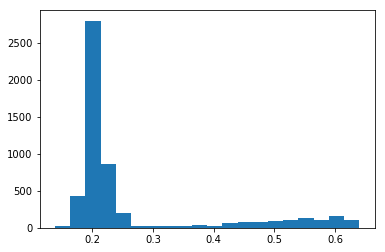

In [20]:
import matplotlib.pyplot as plt
plt.hist(marginals, bins=20)
plt.show()

In [21]:
from snorkel.annotations import load_gold_labels

L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1, load_as_array=True, zero_one=True)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2, zero_one=True)

**Recall-uncorrected Score** If we don't account for candidates missed during extraction, our model score will overestimate real performance, as is the case for the model evaluation below.

In [26]:
brat.score(session, test_cands, marginals, "spouse/test-subset", recall_correction=False)

Unadjusted BRAT Scores (10 Documents)
Pos. class accuracy: 0.75
Neg. class accuracy: 0.852
Precision            0.25
Recall               0.75
F1                   0.375
----------------------------------------
TP: 6 | FP: 18 | TN: 104 | FN: 2



Mapped 8/11 (73%) of BRAT labels to candidates


**Recall-corrected Score** Though this is a small sample of documents, we see how missing candidates can impact our real system score. 

In [25]:
brat.score(session, test_cands, marginals, "spouse/test-subset")

Adjusted BRAT Scores (10 Documents)
Pos. class accuracy: 0.545
Neg. class accuracy: 0.852
Precision            0.25
Recall               0.545
F1                   0.343
----------------------------------------
TP: 6 | FP: 18 | TN: 104 | FN: 5



Mapped 8/11 (73%) of BRAT labels to candidates


This is the full model, evaluated on all our gold candidate labels. 

In [24]:
tp, fp, tn, fn = lstm.error_analysis(session, test_cands, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.627
Neg. class accuracy: 0.923
Precision            0.426
Recall               0.627
F1                   0.507
----------------------------------------
TP: 281 | FP: 379 | TN: 4567 | FN: 167

